In [7]:
from __future__ import annotations
import warnings
from pathlib import Path
from typing import Optional, Any
import numpy as np
from tifffile import TiffFile, TiffWriter
from yaml import load, dump
import cv2
import os
%matplotlib inline
from matplotlib import pyplot as plt

dataset_path = os.path.abspath(os.getcwd()) + '\\binary-masks\\'
# dataset_path = os.path.abspath(os.getcwd()) + '\\flat-fielded\\'
print(dataset_path)



def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader as Loader, Dumper as Dumper

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_stiff(filename: str | Path, silent=False, rgb_only=False, normalize=True):
    """

    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """
    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    
    
    
    img = mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()



    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page = first_band_page + 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!')

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
            tag_value = tag.value if tag else ''
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    raise RuntimeError(f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!')

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        #
        # The metadata should be in the form of a YAML document.
        if metadata:
            metadata = metadata.encode('ascii').decode('unicode-escape')
            metadata = load(metadata, Loader=Loader)
        else:
            metadata = ''

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == 'uint16' and normalize:
        spim = spim.astype('float32') / (2**16 - 1)

    return spim, np.array(wavelengths, 'float32'), rgb, metadata


def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-escape encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.


    10 different classes not all are used in every image
    """
    TIFFTAG_MASK_LABEL = 65001
    masks = dict()
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            if label_tag is None:
                if p > 0:
                    print(f'** page {p}: no TIFF_MASK_LABEL tag. Ignored.')
                continue
            label = label_tag.value.encode('ascii').decode('unicode-escape')
            # print("Label")
            # print(label)
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
            # print(masks[label])
            # return masks and the label
    return masks,label

## Load Images From The Folder

def load_images_from_folder(folder):
    images = []
    readings_of_mtiff = []
    for filename in os.listdir(folder):

        
        full_path = folder + filename
        # image_array = read_stiff(filename=full_path, silent=False, rgb_only=False, normalize=True)
        # read_mtiff_output = read_mtiff(full_path)

        mtiff_output = read_mtiff(full_path)
        print(filename)
        # img = cv2.imread(os.path.join(folder,filename))
        # plt.imshow(img)
        # plt.show()
        
        # print(mtiff_output)

        mtiff_output_pre_process(mtiff_output, filename)
        # mtiff_output_pre_process(mtiff_output)


        # readings_of_mtiff.append(read_mtiff_output)

        # img = cv2.imread(os.path.join(folder,filename))
        # if img is not None:
        #     images.append(img)
    return readings_of_mtiff





def mtiff_output_pre_process(read_mtiff_output, filename):
    print("preprocess func")
    print(type(read_mtiff_output))
    
    
    label = read_mtiff_output[1]
    mask = read_mtiff_output[0]
    used_masks = []


    # print("Mask", mask)
    print("label", label)
    print("Mask",  mask)
    print(len(mask))
    
    for i in mask:
        print("Mask Content")
        print(i)
        print(mask[i][0])
    print("file name", filename)

    print("end")



c:\industryproject\notebooks\binary-masks\


In [8]:
load_images_from_folder(dataset_path)

Set 1, blue dye, mask.tif
preprocess func
<class 'tuple'>
label Blue dye
Mask {'Blue dye': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
1
Mask Content
Blue dye
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
file name Set 1, blue dye, mask.tif
end
Set 1, ICG, mask.tif
preprocess func
<class 'tuple'>
label ICG
Mask {'ICG': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, Fa

[]

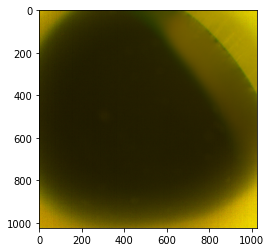

** page 1: no TIFF_MASK_LABEL tag. Ignored.
** page 2: no TIFF_MASK_LABEL tag. Ignored.
** page 3: no TIFF_MASK_LABEL tag. Ignored.
** page 4: no TIFF_MASK_LABEL tag. Ignored.
** page 5: no TIFF_MASK_LABEL tag. Ignored.
** page 6: no TIFF_MASK_LABEL tag. Ignored.
** page 7: no TIFF_MASK_LABEL tag. Ignored.
** page 8: no TIFF_MASK_LABEL tag. Ignored.
** page 9: no TIFF_MASK_LABEL tag. Ignored.
** page 10: no TIFF_MASK_LABEL tag. Ignored.
** page 11: no TIFF_MASK_LABEL tag. Ignored.
** page 12: no TIFF_MASK_LABEL tag. Ignored.
** page 13: no TIFF_MASK_LABEL tag. Ignored.
** page 14: no TIFF_MASK_LABEL tag. Ignored.
** page 15: no TIFF_MASK_LABEL tag. Ignored.
** page 16: no TIFF_MASK_LABEL tag. Ignored.
** page 17: no TIFF_MASK_LABEL tag. Ignored.
** page 18: no TIFF_MASK_LABEL tag. Ignored.
** page 19: no TIFF_MASK_LABEL tag. Ignored.
** page 20: no TIFF_MASK_LABEL tag. Ignored.
** page 21: no TIFF_MASK_LABEL tag. Ignored.
** page 22: no TIFF_MASK_LABEL tag. Ignored.
** page 23: no TIFF

UnboundLocalError: local variable 'label' referenced before assignment

In [54]:
image_array = read_stiff(filename="flat-fielded/Set 1, blue dye.tif", silent=False, rgb_only=False, normalize=True)
mtiff_read = read_mtiff(filename="flat-fielded/Set 1, blue dye.tif")


In [3]:
print(image_array)
print(type(image_array))

(array([[[0.516701  , 0.28960097, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.9614862 , 0.7084306 , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.9835813 , 0.0489662 , 0.2300908 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.53597313,
         0.5692836 , 1.        ],
        [0.        , 1.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[0.33582056, 0.40732434, 0.19928282, ..., 0.71735716,
         0.        , 1.        ],
        [0.18724346, 0.43714046, 0.        , ..., 0.38408485,
         0.18785381, 0.5979095 ],
        [1.        , 0.5309224 , 0.3461204 , ..., 0.15803769,
         0.        , 0.23192187],
        ...,
        [1.        , 0.98315406, 0.5863279 , ..., 0.394934  ,
         0.3588159 , 1.        ],
        [1.